In [1]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import seaborn as sns  # visualization library
import matplotlib.pyplot as plt  # another visualization library



In [2]:
df = pd.read_csv('input_ds/virus_hw5.csv', sep=',', header=0)

In [3]:
# remove all the irrelevant fields 
relevant_features = ["DisciplineScore", "TimeOnSocialActivities", "AgeGroup", "StepsPerYear",
                     "pcrResult4", "pcrResult1", "pcrResult12", "pcrResult5", "pcrResult16",
                     "pcrResult14", "SyndromeClass"]

mean_discipline = 4.95
mean_social_activity_time = 5.32

results_fields = ['Disease', 'Spreader', 'atRisk']

## DISCIPLINE SCORE

In [4]:
# DisciplineScoreHandler


# any value above 10 will be divided by 10

outlier_discipline_score = df.DisciplineScore > 10

df.loc[outlier_discipline_score, "DisciplineScore"] = df.loc[outlier_discipline_score, "DisciplineScore"] / 10

# fill others with mean
# replace the NA values with mean
df.DisciplineScore = df.DisciplineScore.fillna(mean_discipline)

## SOCIAL ACTIVITIES

In [5]:
# SocialActivitiesHandler

no_social_activities_score_mask = df.TimeOnSocialActivities.isna()
invalid_activities_score_mask = df.TimeOnSocialActivities < 5

# check where it is not nan at AvgHouseholdExpenseOnPresents
no_expenses_expenses_mask = df.AvgHouseholdExpenseOnPresents.isna()

# merge 2 masks
social_activities_na_refill_series = no_social_activities_score_mask & ~no_expenses_expenses_mask
social_activities_invalid_refill_series = invalid_activities_score_mask & ~no_expenses_expenses_mask


df.loc[social_activities_na_refill_series, "TimeOnSocialActivities"] = df.loc[social_activities_na_refill_series, "AvgHouseholdExpenseOnPresents"] / 10
df.loc[social_activities_invalid_refill_series, "TimeOnSocialActivities"] = df.loc[social_activities_invalid_refill_series, "AvgHouseholdExpenseOnPresents"] / 10

# all the other missing data will receive the mean value, since no other dependency was found.

# replace the NA values with mean
# calculate new mean_social_activity_time
mean_social_activity_time = df.TimeOnSocialActivities.mean()

df.TimeOnSocialActivities = df.TimeOnSocialActivities.fillna(mean_social_activity_time)


## AGE HANDLER

In [6]:
# Age Handler

# For StepsPerYear, find mean value for each age group
# For AvgMinSportsPerDay, find mean value for each age group
# Then is age is missing, but of [StepsPerYear, AvgMinSportsPerDay] exists, find closest and fill this age

no_age_idxs = df.AgeGroup.isna()

age_values = df.AgeGroup[~no_age_idxs].unique().astype("int")   # array([3, 2, 6, 4, 5, 7, 1, 8, 0])
age_values.sort()  # array([0, 1, 2, 3, 4, 5, 6, 7, 8])

mean_steps_vs_age = {}
mean_avg_sports_vs_age = {}

min_steps_vs_age = {}
min_avg_sports_vs_age = {}

max_steps_vs_age = {}
max_avg_sports_vs_age = {}

for age_value in age_values:
    mask = df.AgeGroup == age_value
    
    mean_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.mean())
    mean_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.mean())
    
    min_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.min())
    min_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.min())
    
    max_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.max())
    max_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.max())    
    

# for now fill with mean
df['AgeGroup'] = df.AgeGroup.fillna(np.mean(df.AgeGroup))
    

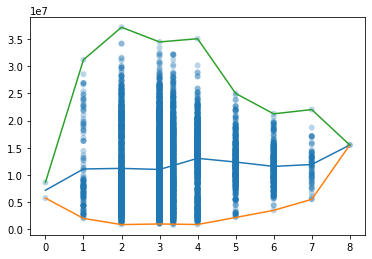

In [7]:
fig, ax = plt.subplots()

ax.scatter(df.AgeGroup, df.StepsPerYear, alpha=0.3, edgecolors='none')
ax.plot(mean_steps_vs_age.keys(), mean_steps_vs_age.values())
ax.plot(min_steps_vs_age.keys(), min_steps_vs_age.values())
ax.plot(max_steps_vs_age.keys(), max_steps_vs_age.values())

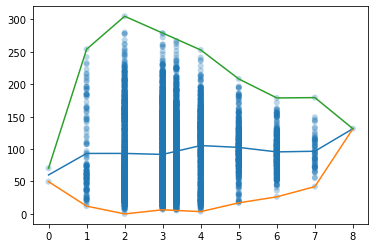

In [8]:
fig, ax = plt.subplots()

ax.scatter(df.AgeGroup, df.AvgMinSportsPerDay, alpha=0.3, edgecolors='none')
ax.plot(mean_avg_sports_vs_age.keys(), mean_avg_sports_vs_age.values())
ax.plot(min_avg_sports_vs_age.keys(), min_avg_sports_vs_age.values())
ax.plot(max_avg_sports_vs_age.keys(), max_avg_sports_vs_age.values())

In [9]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

## STEPS PER YEAR

In [10]:
# StepsPerYear handler

# fill the missing StepsPerYear with AvgMinSportsPerDay
no_StepsPerYear_score_mask = df.StepsPerYear.isna()

# check where it is not nan at AvgMinSportsPerDay
AvgMinSportsPerDay_mask = df.AvgMinSportsPerDay.isna()

# merge 2 masks
StepsPerYear_na_refill_series = no_StepsPerYear_score_mask & ~AvgMinSportsPerDay_mask

delta = 1.75*(10**7) / 150 # from graph
df.loc[StepsPerYear_na_refill_series, "StepsPerYear"] = df.loc[StepsPerYear_na_refill_series, "AvgMinSportsPerDay"] * delta

# all the other missing data will receive the mean value, since no other dependency was found.

# replace the NA values with mean
mean_StepsPerYear = df.StepsPerYear.mean()

df['StepsPerYear'] = df.StepsPerYear.fillna(np.mean(df.StepsPerYear))

## PCR RESULTS

In [11]:
# Dead with PCR results

from sklearn.impute import KNNImputer
from scipy import stats


impute_type = "mean"

df_pcr = df.copy()

pcr_results = [i+1 for i in range(16)]
pcr_fields = ["pcrResult" + str(i) for i in pcr_results]

# leave only PCR columns
for column in df_pcr.columns:
    if column not in pcr_fields and column != "PatientID":
        df_pcr = df_pcr.drop(columns = column)

# validation and test IDs start with offset
ID_offset = df_pcr.PatientID[0]

# for KNN : Replace outliers with mean, later do KNN imputation
# for MEAN : Replace outliers with mean for the current class

for key in pcr_fields:

    new_df = df_pcr[['PatientID', key]].copy()

    # remove nans
    new_df = new_df.dropna()

    IDs_list = list(new_df.PatientID)

    z = np.abs(stats.zscore(new_df[key]))
    outliers_arr = np.where(z > 2)

    if len(outliers_arr[0]) != 0:

        for outlier_idx in outliers_arr[0]:
            # dropping those rows from the new_df for mean calculation
            new_df = new_df.drop(IDs_list[outlier_idx] - ID_offset)

    else:
        pass  # no outliers were detected

    # find the mean WITHOUT the outliers
    new_mean = new_df[key].mean()

    # fill the outliers in the original df with mean / nan
    for outlier_idx in outliers_arr[0]:
        # dropping those rows from the new_df

        if impute_type == "knn":
            # later do the knn imputation on all
            df_pcr.at[IDs_list[outlier_idx] - ID_offset, key] = np.nan
        elif impute_type == "mean":
            # replace the outliers with mean
            df_pcr.at[IDs_list[outlier_idx] - ID_offset, key] = new_mean


if impute_type == "knn":
    # IMPUTER using KNN
    df_pcr = df_pcr.drop(['PatientID'], axis=1)
    imputer = KNNImputer(n_neighbors=3)  # k-nearest neighbors impute,

    df_mx = imputer.fit_transform(df_pcr)
    df_pcr = pd.DataFrame(df_mx, list(df["PatientID"]), pcr_fields)

elif impute_type == "mean":
    df_pcr = df_pcr.fillna(df.mean())

# replace the original pcr columns with new imputed columns
for column in df_pcr.columns:
    df[column] = df_pcr[column]








In [12]:
# SyndromeClass handler

df.SyndromeClass = df.SyndromeClass.fillna(5)

In [13]:
# get the results for the viruses to get the "Correct labels" for clustering


# test result classified by labels
li = df.TestResultsCode.tolist()
labels = [item.split('_') for item in li]
for item in labels:
    if len(item) == 4:
        add = item[0] + item[1]
        item = item.insert(0, add)
for item in labels:
    if 'not' in item:
        item.remove('not')
    if 'detected' in item:
        item.remove('detected')

disease = [la[0] for la in labels]
spread = [la[1] for la in labels]
risk = [la[2] for la in labels]

# mapping dict
# mapping = {}
# for i,x in enumerate(set(disease)):
#     mapping[x] = i

# to be sure we're consistent. is also used in automatic classificaion
disease_mapping = {'flue': 0, 'covid': 1, 'cmv': 2, 'cold': 3, 'measles': 4, 'notdetected': 5}

disease_indexed = [disease_mapping[disease_name] for disease_name in disease]


spread_encode = pd.Series(spread).str.get_dummies()
risk_encode = pd.Series(risk).str.get_dummies()

# disease_encode = pd.DataFrame(disease_encode)
disease_encode = pd.DataFrame({'Disease' : disease_indexed})
spread_encode = pd.DataFrame(spread_encode)
risk_encode = pd.DataFrame(risk_encode)


spread_encode = spread_encode.drop(['NotSpreader'], axis=1)
risk_encode = risk_encode.drop(['NotatRisk'], axis=1)

frames = [df, disease_encode, spread_encode, risk_encode]
df = pd.concat(frames, axis=1)

# drop the original label
df = df.drop(columns='TestResultsCode')

In [14]:
features_to_stay = ["Disease"] + relevant_features

for column in df.columns:
    if column not in features_to_stay:
        df = df.drop(columns = column)

In [15]:
df.head()

,AgeGroup,DisciplineScore,StepsPerYear,SyndromeClass,TimeOnSocialActivities,pcrResult1,pcrResult12,pcrResult14,pcrResult16,pcrResult4,pcrResult5,Disease
0,3.000000,5.00,1.693611e+07,2.0,71.096219,-0.783570,-1.728232,1.239142,0.561232,0.727264,0.007465,0
1,3.360444,8.00,1.298412e+07,3.0,59.209984,-0.288236,-10.181192,0.330100,1.805613,-0.355124,-0.347716,4
2,3.360444,4.95,8.560931e+06,1.0,27.962990,0.590215,0.905512,1.938797,0.743885,-1.234402,0.258255,5
3,3.000000,4.00,1.465361e+07,3.0,49.786640,-1.440436,-0.933486,45.244016,2.612904,0.366601,0.007465,1
4,2.000000,4.00,1.153898e+07,5.0,76.434326,-0.964806,-2.940880,3.368657,0.506867,1.546139,0.217398,1


In [16]:
# use standard scaler

from sklearn.preprocessing import StandardScaler
import copy

df_scaled = copy.deepcopy(df)

sc = StandardScaler()


df_scaled = df_scaled.drop(columns="Disease")

df_scaled_np = sc.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled_np, index=df_scaled.index, columns=df_scaled.columns)

df_scaled["Disease"] = df["Disease"]



In [17]:
df_scaled.head()

,AgeGroup,DisciplineScore,StepsPerYear,SyndromeClass,TimeOnSocialActivities,pcrResult1,pcrResult12,pcrResult14,pcrResult16,pcrResult4,pcrResult5,Disease
0,-0.316986,0.075141,8.538730e-01,-0.785360,1.062702,-1.001072,-0.227207,-0.411893,-1.468764,0.649749,0.003929,0
1,0.000000,2.271522,2.286332e-01,0.008022,0.276271,-0.475688,-2.413755,-0.444356,0.281801,-0.494200,-0.702037,4
2,0.000000,0.038534,-4.711525e-01,-1.578742,-1.791130,0.456054,0.454071,-0.386908,-1.211812,-1.423487,0.502404,5
3,-0.316986,-0.656986,4.927611e-01,0.008022,-0.347208,-1.697787,-0.021628,1.159557,1.417478,0.268573,0.003929,1
4,-1.196418,-0.656986,-2.946863e-16,1.594786,1.415888,-1.193302,-0.540885,-0.335846,-1.545244,1.515198,0.421195,1


# CLUSTERING

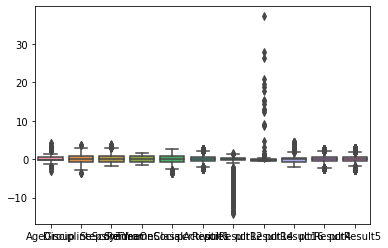

In [18]:
ax = sns.boxplot(data=df_scaled.drop(columns="Disease"))

In [19]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import numpy as np

X = df_scaled.drop(['Disease'], axis=1).values


kmeans = KMeans(n_clusters=6, random_state=0).fit(X)


# clustering_virus = SpectralClustering(n_clusters=6,
#         affinity='nearest_neighbors',
#         assign_labels="discretize",
#         random_state=0).fit(X)

gm = GaussianMixture(n_components=6,  covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

gm = gm.fit(X)


In [20]:
from sklearn.decomposition import PCA

reduced_data_3d = PCA(n_components=3).fit_transform(X)

# labels_clustering = kmeans.labels_
# labels_clustering = clustering_virus.labels_
labels_clustering = gm.predict(X) #labels

# or using the real labels to see that data fits
labels_true = list(df_scaled["Disease"])



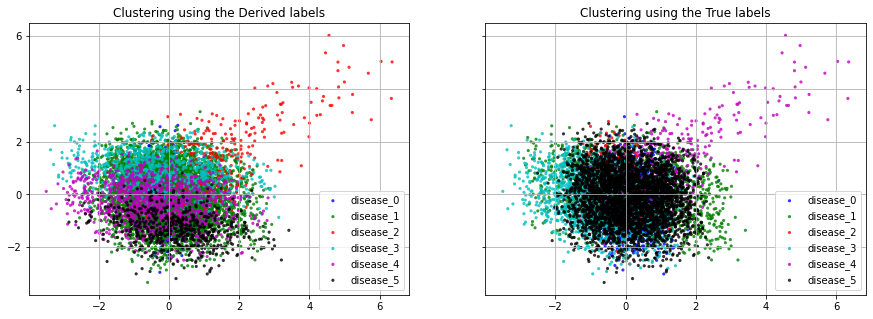

In [21]:
colors = ('b', 'g', 'r', 'c', 'm', 'k')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
axes_to_use = [1,2]

for idx in range(6):
    color = colors[idx]
    
    class_idx_clustering = [index for index, val in enumerate(labels_clustering) if val == idx]

    x_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[0]]
    y_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[1]]   

    ax1.scatter(x_clustering, y_clustering, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')
    
    class_idx_true = [index for index, val in enumerate(labels_true) if val == idx]

    x_true = reduced_data_3d[class_idx_true,axes_to_use[0]]
    y_true = reduced_data_3d[class_idx_true,axes_to_use[1]]    
    
    
    ax2.scatter(x_true, y_true, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')


ax1.legend()
ax1.grid(True)
ax1.set_title("Clustering using the Derived labels")

ax2.legend()
ax2.grid(True)
ax2.set_title("Clustering using the True labels")

plt.show()

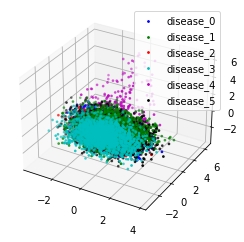

In [243]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for idx in range(6):
    color = colors[idx]
    
    class_idx = [index for index, val in enumerate(labels_kmeans) if val == idx]

    
    x = reduced_data_3d[class_idx,0]
    y = reduced_data_3d[class_idx,1]
    z = reduced_data_3d[class_idx,2]
    

    ax.scatter(x, y, z, c=color, label=f"disease_{idx}", s=3)


ax.legend()
ax.grid(True)

plt.show()

# CLASSIFICATION

In [68]:
# using the adaboost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_true, test_size=0.2, random_state=42)

# n_estimators = 500, estimator = DecisionTreeClassifier(max_depth=3) - gives 0.7 error on test

clf = AdaBoostClassifier(n_estimators=700, 
                         learning_rate=0.07,
                         random_state=0,
                         algorithm = 'SAMME',
                         base_estimator = DecisionTreeClassifier(max_depth=4))
clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.07, n_estimators=700, random_state=0)

In [69]:
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f"Train score : {score_train}")
print(f"Test score : {score_test}")

Train score : 0.8431944444444445
Test score : 0.82


In [ ]:
# SOME HISTORY

# clf = AdaBoostClassifier(n_estimators=500, 
#                          learning_rate=0.1,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4))

# Train score : 0.8444444444444444
# Test score : 0.815
    
# clf = AdaBoostClassifier(n_estimators=700, 
#                          learning_rate=0.1,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4)) 

# Train score : 0.8447222222222223
# Test score : 0.8183333333333334
    
# clf = AdaBoostClassifier(n_estimators=700, 
#                          learning_rate=0.07,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4))   

# Train score : 0.8431944444444445
# Test score : 0.82

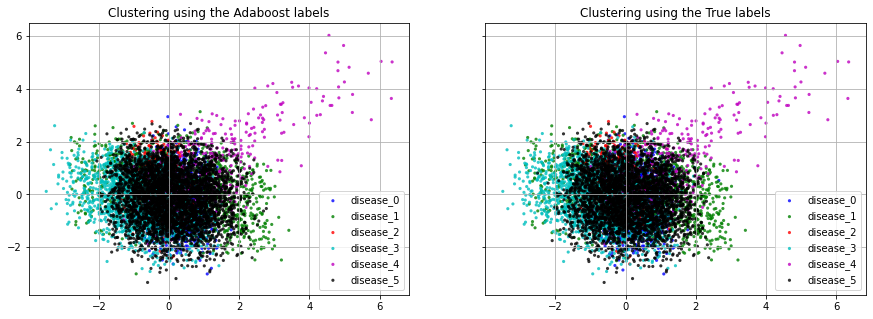

In [82]:
# Vizualizing the true labels and  predicted labels from the adaboost

labels_adaboost = clf.predict(X)

colors = ('b', 'g', 'r', 'c', 'm', 'k')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
axes_to_use = [1,2]

for idx in range(6):
    color = colors[idx]
    
    class_idx_clustering = [index for index, val in enumerate(labels_adaboost) if val == idx]

    x_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[0]]
    y_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[1]]   

    ax1.scatter(x_clustering, y_clustering, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')
    
    class_idx_true = [index for index, val in enumerate(labels_true) if val == idx]

    x_true = reduced_data_3d[class_idx_true,axes_to_use[0]]
    y_true = reduced_data_3d[class_idx_true,axes_to_use[1]]    
    
    
    ax2.scatter(x_true, y_true, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')


ax1.legend()
ax1.grid(True)
ax1.set_title("Clustering using the Adaboost labels")

ax2.legend()
ax2.grid(True)
ax2.set_title("Clustering using the True labels")

plt.show()

In [81]:
for indx, (label_t, label_a) in enumerate(zip(labels_true, labels_adaboost)):
    print(f"{label_t} <-> {label_a} : {label_t == label_a}")
    if indx > 20:
        break
        
l_t_np = np.array(labels_true)
l_a_np = np.array(labels_adaboost)
true_labels = sum(l_t_np == l_a_np)

print(f"True: {true_labels} / {len(labels_true)}")

0 <-> 5 : False
4 <-> 4 : True
5 <-> 3 : False
1 <-> 1 : True
1 <-> 1 : True
0 <-> 0 : True
1 <-> 5 : False
5 <-> 0 : False
5 <-> 5 : True
3 <-> 3 : True
3 <-> 3 : True
4 <-> 4 : True
4 <-> 4 : True
1 <-> 1 : True
1 <-> 1 : True
0 <-> 0 : True
3 <-> 5 : False
5 <-> 5 : True
0 <-> 5 : False
3 <-> 3 : True
2 <-> 5 : False
1 <-> 0 : False
True: 7547 / 9000


array([1])